In [187]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import shap

In [188]:
train = pd.read_csv("train.csv", index_col='id')
print(train.shape)
train.head(2)

(100000, 24)


,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
id,,,,,,,,,,,,,,,,,,,,,
0,2011-1,560,NaN,2,59,3,0,30.0,1.0,5,...,0,0,0,0,0,0,0,0,0,4510000
1,2011-1,667,NaN,10,50,2,1,25.0,NaN,1,...,0,0,0,0,0,0,0,0,0,13231000


In [189]:
test = pd.read_csv("test.csv", index_col='id')
print(test.shape)
test.head(2)

(100000, 23)


,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
id,,,,,,,,,,,,,,,,,,,,,
100000,2012-3,459,NaN,1,60,3,1,30.0,0.0,4,...,0,0,0,0,0,0,0,0,0,0
100001,2012-3,344,1.0,10,52,2,1,NaN,NaN,4,...,0,0,0,0,0,0,0,0,0,0


**Поиск и заполнение пропущенных значений**

In [190]:
def calculate_missing_values(df):
    total_rows = df.shape[0]
    for column in df.columns:
        missing_values = df[column].isnull().sum()
        if missing_values > 0:
            missing_percentage = (missing_values / total_rows) * 100
            print(f"Столбец '{column}' имеет {missing_percentage:.2f}% пропущенных значений, тип данных: '{df[column].dtype}'")

calculate_missing_values(train)

Столбец 'build_tech' имеет 29.73% пропущенных значений, тип данных: 'float64'
Столбец 'metro_dist' имеет 4.90% пропущенных значений, тип данных: 'float64'
Столбец 'g_lift' имеет 29.99% пропущенных значений, тип данных: 'float64'


In [191]:
#Округление значения до ближайшего значения из unique_metro_dists
def round_to_nearest(value, unique_metro_dists):
    nearest_value = min(unique_metro_dists, key=lambda x: abs(x - value))
    return nearest_value

In [192]:
def preprocessing(df):
    #Заполнение средним по street_id
    unique_metro_dists = df['metro_dist'].unique()
    df['metro_dist'].fillna(df.groupby('street_id')['metro_dist'].transform('mean'), inplace=True)
    df['metro_dist'].fillna(df['metro_dist'].mean(), inplace=True)
    df['metro_dist'] = df['metro_dist'].apply(round_to_nearest, args=(unique_metro_dists,))

    df['build_tech'].fillna(df.groupby('street_id')['build_tech'].agg(lambda x: x.value_counts().index[0]), inplace=True)
    df['build_tech'].fillna(df['build_tech'].agg(lambda x: x.value_counts().index[0]), inplace=True)

    df['g_lift'].fillna(df.groupby('street_id')['g_lift'].agg(lambda x: x.value_counts().index[0]), inplace=True)
    df['g_lift'].fillna(df['g_lift'].agg(lambda x: x.value_counts().index[0]), inplace=True)

    datetime = pd.DatetimeIndex(df['date'])
    df['date'] = (datetime.year - 2011) * 12 + datetime.month
    
    #df['area'] = df['area'].apply(lambda x : x**0.5)
    #df['metro_dist'] = df['metro_dist'].apply(lambda x : x**0.5)
    
    #df = pd.get_dummies(df, columns=['street_id'], drop_first=True)
    
    #df.drop(['date'], axis=1, inplace=True)
    
    #df.drop(['kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw12', 'kw13', 'kw11', 'kw3'], axis=1, inplace=True)
    
    return df

**Даты в train и test не совпадают, видно, что данные были разделены именно по ним, можно их удалить**

In [193]:
train = preprocessing(train)
calculate_missing_values(train)

In [194]:
test = preprocessing(test)
calculate_missing_values(test)

In [195]:
print(train['date'].unique())
print(test['date'].unique())

[ 1 10 11 12  2  3  4  5  6  7  8  9 13 22 23 24 14 15]
[15 16 17 18 19 20 21 25 34 35 36 26 27 28 29 30 31 32 33]


In [196]:
for i in range(1, 14):
    print(f"train['kw{i}'].unique():")
    print(train[f'kw{i}'].unique())

train['kw1'].unique():
[0 1]
train['kw2'].unique():
[1 0]
train['kw3'].unique():
[0 1]
train['kw4'].unique():
[0 1]
train['kw5'].unique():
[0 1]
train['kw6'].unique():
[0 1]
train['kw7'].unique():
[0 1]
train['kw8'].unique():
[0 1]
train['kw9'].unique():
[0 1]
train['kw10'].unique():
[0 1]
train['kw11'].unique():
[0 1]
train['kw12'].unique():
[0 1]
train['kw13'].unique():
[0 1]


**Подготовка данных к обучению и тестированию**

In [197]:
test.head(3)

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
id,,,,,,,,,,,,,,,,,,,,,
100000,15,459,0.0,1,60,3,1,30.0,0.0,4,...,0,0,0,0,0,0,0,0,0,0
100001,15,344,1.0,10,52,2,1,30.0,0.0,4,...,0,0,0,0,0,0,0,0,0,0
100002,15,585,0.0,4,54,3,0,30.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [198]:
y = train['price']
X = train.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=13)

**Градиентный бустинг**

In [199]:
categorical_features = ['street_id', 'rooms', 'balcon'
#                        , 'build_tech', 'g_lift'
#                        , 'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13'
]

In [17]:
boosting_model = CatBoostRegressor(iterations=3000,
                           loss_function='MAE',  
                           eval_metric='MAE', 
                           objective='MAE',
                           logging_level='Silent',
                           cat_features=categorical_features,
                           early_stopping_rounds=1000,
                           random_seed=13)
grid = {
    'learning_rate': [0.10, 0.14, 0.15, 0.16, 0.2],
    'depth': [5,6,7]
}
grid_search_result = boosting_model.grid_search(grid, 
                                               X=X_train, 
                                               y=y_train,
                                               cv=5,
                                               train_size=0.8,
                                               plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 652474.7558146	best: 652474.7558146 (0)	total: 1m 42s	remaining: 23m 49s
1:	loss: 658484.2946227	best: 652474.7558146 (0)	total: 3m 21s	remaining: 21m 50s
2:	loss: 658661.7161053	best: 652474.7558146 (0)	total: 5m 1s	remaining: 20m 5s
3:	loss: 657445.6740063	best: 652474.7558146 (0)	total: 6m 41s	remaining: 18m 24s
4:	loss: 657652.4636899	best: 652474.7558146 (0)	total: 8m 21s	remaining: 16m 43s
5:	loss: 649998.0445636	best: 649998.0445636 (5)	total: 10m 20s	remaining: 15m 30s
6:	loss: 648681.5255043	best: 648681.5255043 (6)	total: 12m 23s	remaining: 14m 9s
7:	loss: 649354.2423178	best: 648681.5255043 (6)	total: 14m 33s	remaining: 12m 44s
8:	loss: 653734.5984857	best: 648681.5255043 (6)	total: 16m 46s	remaining: 11m 10s
9:	loss: 653662.0017060	best: 648681.5255043 (6)	total: 18m 56s	remaining: 9m 28s
10:	loss: 649810.6486716	best: 648681.5255043 (6)	total: 21m 27s	remaining: 7m 48s
11:	loss: 651829.7108063	best: 648681.5255043 (6)	total: 24m	remaining: 6m
12:	loss: 650638.1809

In [18]:
print("Best model parameters: " + str(grid_search_result['params'])) 
print("Model test score: " + str(round(mean_absolute_error(boosting_model.predict(X_test), y_test))))
print("Competition score: " + str(1 / (1 + mean_absolute_error(boosting_model.predict(X_test), y_test))))

Best model parameters: {'depth': 6, 'learning_rate': 0.14}
Model test score: 616504
Competition score: 1.6220478224273583e-06


**Тестирование различных вариаций лечшего алгоритма**

In [216]:
best_model = 
CatBoostRegressor(iterations=10000,
                  loss_function='MAE',  
                  eval_metric='MAE',
                  logging_level='Silent',
                  depth=6,
                  learning_rate=0.05,
                  cat_features=categorical_features,
                  early_stopping_rounds=2000)
best_model.fit(X_train, y_train)

In [ ]:
#Лучший результат
#605972

In [217]:
y_pred = best_model.predict(X_test)
print("Model test score: " + str(round(mean_absolute_error(y_pred, y_test))))
print("Competition score: " + str(1 / (1 + mean_absolute_error(y_pred, y_test))))

Model test score: 605972
Competition score: 1.6502381410969108e-06


In [137]:
#Сравнение предсказаний
for i in range(10):
    print("pred: " + str(round(y_pred[i])) + "  test: " + str(y_test.iloc[i]))

pred: 3039123  test: 2928000
pred: 7734283  test: 7249000
pred: 2117274  test: 2184000
pred: 2404961  test: 2647000
pred: 3761398  test: 3254000
pred: 3356469  test: 3500000
pred: 5074524  test: 4788000
pred: 2229722  test: 2258000
pred: 3613606  test: 3815000
pred: 5231380  test: 4768000


**Пробую подобрать порог и немного изменить предсказания, на основании анализа результатов**

In [208]:
pred_over = 0
pred_over_count = 0
pred_lover = 0
pred_lover_count = 0
for i in range(len(y_pred)):
    if y_pred[i] > 400000:  
        el = y_pred[i] * 1.001
    else:
        el = y_pred[i] * 0.999
    if el > y_test.iloc[i]:
        pred_over += el - y_test.iloc[i]
        pred_over_count += 1
    else:
        pred_lover += y_test.iloc[i] - el
        pred_lover_count += 1

In [207]:
print(pred_over)
print(pred_over_count)
print(pred_lover)
print(pred_lover_count)
print(pred_over + pred_lover)

6967856871.63658
9877
5182057034.550411
10123
12149913906.186993


In [209]:
print(pred_over)
print(pred_over_count)
print(pred_lover)
print(pred_lover_count)
print(pred_over + pred_lover)

6916890557.313037
9795
5234967767.017168
10205
12151858324.330204


**Важность фичей**

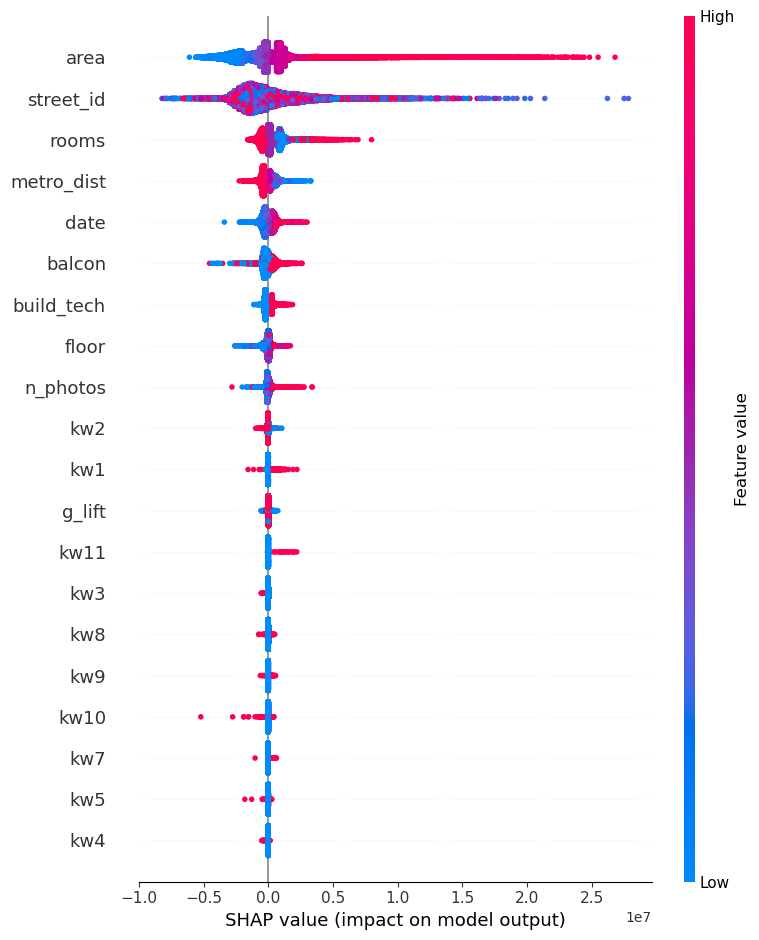

In [163]:
explainer = shap.TreeExplainer(best_model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

**Дерево решений (слишком слабый алгоритм)**

In [39]:
tree_model = DecisionTreeRegressor(criterion="squared_error", max_depth=10)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [40]:
print("Model test score: " + str(round(mean_absolute_error(tree_model.predict(X_test), y_test))))

Model test score: 1819201


**Случайный лес (работает дольше и дает менее точные предсказания)**

In [105]:
parameters = {'n_estimators': [3000],
             'max_depth': [10, 15, 20]}
clf = RandomForestRegressor(criterion="squared_error")
gs_clf = GridSearchCV(clf, parameters, cv=5, n_jobs=-1)
gs_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20], 'n_estimators': [3000]})

In [106]:
print("Best model parameters: " + str(gs_clf.best_params_)) 
print("Model test score: " + str(round(mean_absolute_error(gs_clf.best_estimator_.predict(X_test), y_test))))
print("Competition score: " + str(1 / (1 + mean_absolute_error(gs_clf.best_estimator_.predict(X_test), y_test))))

Best model parameters: {'max_depth': 20, 'n_estimators': 3000}
Model test score: 1618756
Competition score: 6.177579311737805e-07


In [ ]:
#'max_depth': 30, 'n_estimators': 1500
#1575394

In [24]:
best_rf_model = RandomForestRegressor(criterion="squared_error", max_depth=30, n_estimators=3000)
best_rf_model.fit(X, y)

RandomForestRegressor(max_depth=30, n_estimators=3000)

**Финальная модель и предсказание результатов**

In [220]:
best_model = CatBoostRegressor(iterations=10000,
                               loss_function='MAE',  
                               eval_metric='MAE',  
                               logging_level='Silent',
                               depth=6,
                               learning_rate=0.05,
                               cat_features=categorical_features,
                               early_stopping_rounds=3000)
best_model.fit(X, y)

In [221]:
y_pred = best_model.predict(test)

In [222]:
submission = pd.DataFrame({'id':test.index, 'price':y_pred})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,price
0,100000,8.424037e+06
1,100001,4.203325e+06
2,100002,3.853761e+06
3,100003,2.954943e+06
4,100004,6.812780e+06


**Усредненные результаты Бустинг + случаный лес (хуже)**

In [23]:
y_pred_boost = best_model.predict(test)
y_pred_forest = best_rf_model.predict(test)
y_pred_avg = (y_pred_boost + y_pred_forest) / 2

In [24]:
submission = pd.DataFrame({'id':test.index, 'price':y_pred_avg})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,price
0,100000,6.589131e+06
1,100001,4.439254e+06
2,100002,3.205401e+06
3,100003,3.800154e+06
4,100004,5.821909e+06
